In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, load_metric
from tqdm import tqdm

In [2]:
os.chdir('../..')

## Load prediction files

In [3]:
PREDICTION_PATH = 'predictions/albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed={}/'
SEEDS = [27, 28, 29]
BATCH_SIZE = 32

In [4]:
# Created nested dictionary containing all eval_predictions.json filepaths
prediction_filepath_dict = {}

for seed in SEEDS:
    
    checkpoint_str = list(
        os.walk(PREDICTION_PATH.format(seed))
    )[0][1]
    
    checkpoint_nbr = [int(x.split('-')[-1]) for x in checkpoint_str]
    
    checkpoint_fp = [PREDICTION_PATH.format(seed) + x + '/eval_predictions.json' for x in checkpoint_str]
    
    prediction_filepath_dict[seed] = dict(zip(checkpoint_nbr, checkpoint_fp))

In [5]:
predictions_df = pd.DataFrame()

for seed in tqdm(SEEDS):
    for checkpoint, fp in prediction_filepath_dict[seed].items():
        eval_predictions_df = pd.read_json(fp, orient='index')
        eval_predictions_df.reset_index(inplace=True)
        eval_predictions_df.rename(columns={'index': 'id', 0: "prediction_text"}, inplace=True)
        eval_predictions_df['checkpoint'] = checkpoint
        eval_predictions_df['seed'] = seed

        predictions_df = predictions_df.append(eval_predictions_df)

100%|██████████| 3/3 [01:32<00:00, 30.93s/it]


In [6]:
print(predictions_df.shape)
predictions_df.head()

(2528949, 4)


,id,prediction_text,checkpoint,seed
0,56ddde6b9a695914005b9628,; French: Normand,1,27
1,56ddde6b9a695914005b9629,mixing with the native Frankish and Roman-Gaul...,1,27
2,56ddde6b9a695914005b962a,identity of the Normans emerged initially,1,27
3,56ddde6b9a695914005b962b,identity of the Normans emerged initially,1,27
4,56ddde6b9a695914005b962c,; French: Normand,1,27


In [7]:
11873*3*71

2528949

## Load labels

In [8]:
squad_v2_val = load_dataset('squad_v2', split='validation')

Reusing dataset squad_v2 (/home/sgeorge/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/ba48bc29b974701e9ba8d80ac94f3e3df924aba41b764dcf9851debea7c672e4)


In [9]:
squad_v2_val_df = pd.DataFrame(squad_v2_val)
print(squad_v2_val_df.shape)
squad_v2_val_df.head()

(11873, 5)


,answers,context,id,question,title
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans


## Merge with categories

In [10]:
squad2_categories = pd.read_csv('data/processed/squad2_dev_simple_categories.csv')
print(squad2_categories.shape)
squad2_categories.head()

(11873, 6)


,id,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable
0,56ddde6b9a695914005b9628,other,100-200,5-10,1,0
1,56ddde6b9a695914005b9629,when,100-200,5-10,4,0
2,56ddde6b9a695914005b962a,other,100-200,5-10,4,0
3,56ddde6b9a695914005b962b,who,100-200,0-5,1,0
4,56ddde6b9a695914005b962c,what,100-200,5-10,1,0


In [11]:
combined = predictions_df.merge(squad_v2_val_df, on='id', how='inner')

assert combined.shape[0] == predictions_df.shape[0]

combined.head()

,id,prediction_text,checkpoint,seed,answers,context,question,title
0,56ddde6b9a695914005b9628,; French: Normand,1,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
1,56ddde6b9a695914005b9628,; French: Normand,2,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
2,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,4,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
3,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,8,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
4,56ddde6b9a695914005b9628,France,128,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans


In [12]:
combined = combined.merge(squad2_categories, on='id', how='inner')

assert combined.shape[0] == predictions_df.shape[0]

combined.head()

,id,prediction_text,checkpoint,seed,answers,context,question,title,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable
0,56ddde6b9a695914005b9628,; French: Normand,1,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
1,56ddde6b9a695914005b9628,; French: Normand,2,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
2,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,4,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
3,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,8,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
4,56ddde6b9a695914005b9628,France,128,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0


Get number of examples seen for each checkpoint

In [13]:
combined['num_examples'] = combined['checkpoint'] * BATCH_SIZE

## Evaluation function

In [14]:
SQUAD_V2_METRIC = load_metric("squad_v2")

In [15]:
SQUAD_V2_METRIC

Metric(name: "squad_v2", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None), 'no_answer_probability': Value(dtype='float32', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD v2 scores (F1 and EM).
Args:
    predictions: List of triple for question-answers to score with the following elements:
        - the question-answer 'id' field as given in the references (see below)
        - the text of the answer
        - the probability that the question has no answer
    references: List of question-answers dictionaries with the following key-values:
            - 'id': id of the question-answer pair (see above),
            - 'answers': a list of Dict {'text': text of the answer as a string}
    no_answer_threshold: float
        Probability threshold

In [16]:
def squad2_evaluation(id_list, prediction_text_list, answers_list):
    predictions = [
        {
            'prediction_text': prediction_text, 
            'id': _id, 
            'no_answer_probability': 0.0  # Same as https://github.com/huggingface/transformers/blob/master/examples/pytorch/question-answering/run_qa.py#L532
        } for 
        _id, prediction_text in zip(id_list, prediction_text_list)
    ]
    
    references = [
        {
            'id': _id, 
            'answers': answers
        } for 
        _id, answers in zip(id_list, answers_list)
    ]
    
    metrics = SQUAD_V2_METRIC.compute(predictions=predictions, references=references)
    
    return metrics

Check:

In [17]:
np.random.seed(3)
combined.sample(n=1)

MemoryError: Unable to allocate 193. MiB for an array with shape (10, 2528949) and data type object

In [ ]:
squad2_evaluation(
    id_list=list(combined[(combined['checkpoint'] == 6016) & (combined['seed'] == 29)]['id']), 
    prediction_text_list=list(combined[(combined['checkpoint'] == 6016) & (combined['seed'] == 29)]['prediction_text']), 
    answers_list=list(combined[(combined['checkpoint'] == 6016) & (combined['seed'] == 29)]['answers'])
)

In [ ]:
np.random.seed(33)
combined.sample(n=1)

In [ ]:
squad2_evaluation(
    id_list=list(combined[(combined['checkpoint'] == 4864) & (combined['seed'] == 28)]['id']), 
    prediction_text_list=list(combined[(combined['checkpoint'] == 4864) & (combined['seed'] == 28)]['prediction_text']), 
    answers_list=list(combined[(combined['checkpoint'] == 4864) & (combined['seed'] == 28)]['answers'])
)

Both match values in `eval_results.json`

In [ ]:
overall_f1_perf = []

for seed in SEEDS:
    for checkpoint in tqdm(combined['checkpoint'].unique()):
        
        subset = combined.copy()[(combined['checkpoint'] == checkpoint) & (combined['seed'] == seed)]
        
        eval_output = squad2_evaluation(
            id_list=list(subset['id']), 
            prediction_text_list=list(subset['prediction_text']), 
            answers_list=list(subset['answers'])
        )

        overall_f1_perf.append(
            {
                'seed': seed,
                'overall_f1': eval_output['f1'],
                'checkpoint': checkpoint,
                'overall_exact': eval_output['exact']
            }
        )

In [ ]:
overall_f1_perf_df = pd.DataFrame(overall_f1_perf)
print(overall_f1_perf_df.shape)
overall_f1_perf_df.head()

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=overall_f1_perf_df, x='checkpoint', y='overall_f1')
plt.show()

In [ ]:
combined.shape

In [ ]:
combined = combined.merge(overall_f1_perf_df, on=['checkpoint', 'seed'])
combined.shape

## Plots

### WWWWWWH questions

In [ ]:
combined.head()

In [ ]:
combined['w8h_label'].unique()

In [ ]:
combined['w8h_label'].nunique()

In [ ]:
8*3*71

In [ ]:
full_metrics = []

for seed, num_examples, label in tqdm(
    list(
        itertools.product(
            SEEDS, 
            combined['num_examples'].unique(), 
            combined['w8h_label'].unique()
        )
    )
):

    combined_subset = combined.copy()[
        (combined['w8h_label'] == label) & 
        (combined['num_examples'] == num_examples) &
        (combined['seed'] == seed)
    ]

    id_list = list(combined_subset['id'])
    prediction_text_list = list(combined_subset['prediction_text'])
    answers_list = list(combined_subset['answers'])

    metrics = squad2_evaluation(
        id_list=id_list, 
        prediction_text_list=prediction_text_list, 
        answers_list=answers_list
    )

    metrics['w8h_label'] = label
    metrics['num_examples'] = num_examples
    metrics['seed'] = seed

    full_metrics.append(metrics)

In [ ]:
full_metrics_df = pd.DataFrame(full_metrics)
print(full_metrics_df.shape)
full_metrics_df.head()

In [ ]:
full_metrics_df['checkpoint'] = full_metrics_df['num_examples'] / BATCH_SIZE

In [ ]:
full_metrics_df = full_metrics_df.merge(overall_f1_perf_df, on=['seed', 'checkpoint'])
full_metrics_df.shape

In [ ]:
full_metrics_df.to_csv('data/processed/metrics_by_w6h-albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384.csv', index=False)

__WWWWWWH F1 by number of examples__

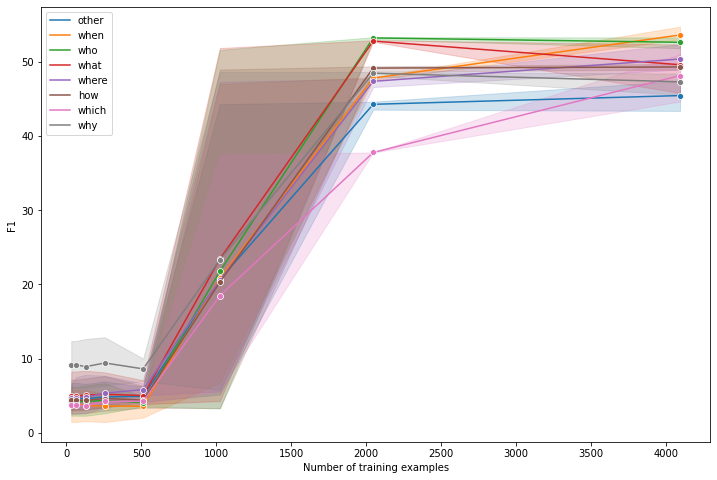

In [40]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df, y='f1', x='num_examples', hue='w8h_label', marker='o', palette='tab10')
plt.legend()
plt.show()

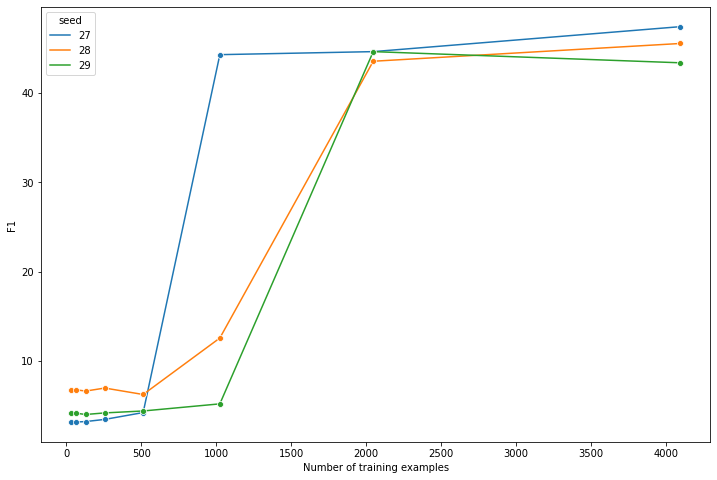

In [42]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df[full_metrics_df['w8h_label'] == 'other'], y='f1', x='num_examples', hue='seed', marker='o', palette='tab10')
plt.legend(title='seed')
plt.show()

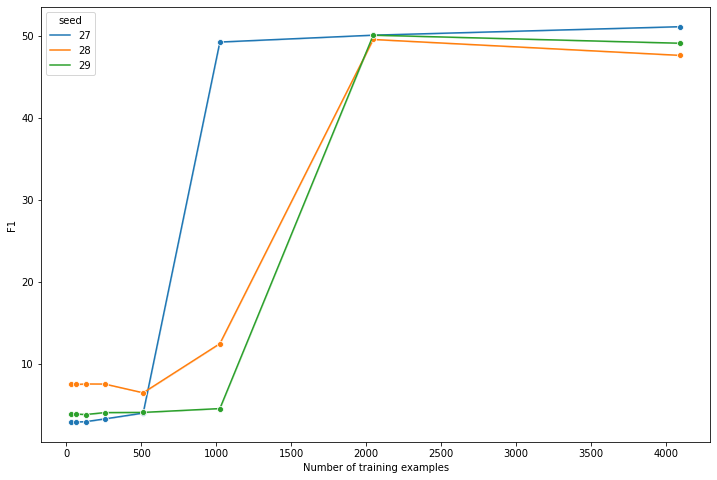

In [44]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df, y='overall_f1', x='num_examples', hue='seed', marker='o', palette='tab10')
plt.legend(title='seed')
plt.show()

### OLD:

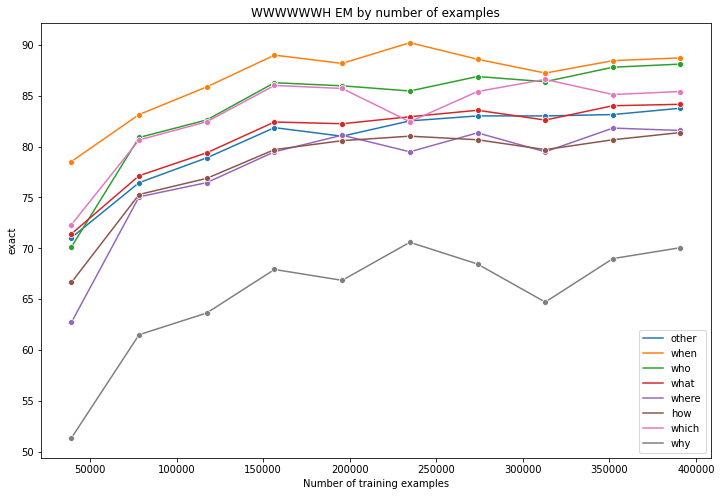

In [56]:
plt.figure(figsize=(12, 8))
plt.title('WWWWWWH EM by number of examples')
plt.xlabel('Number of training examples')
sns.lineplot(data=full_metrics_df, y='exact', x='num_examples', hue='w8h_label', marker='o', palette='tab10')
plt.legend()
plt.show()

### Answerable/Unanswerable

In [57]:
combined.head()

,id,prediction_text,checkpoint,answers,context,question,title,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable,num_examples,overall_F1
0,56ddde6b9a695914005b9628,France,0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0,39120,74.620678
1,56ddde6b9a695914005b9629,10th and 11th centuries,0,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,Normans,when,100-200,5-10,4,0,39120,74.620678
2,56ddde6b9a695914005b962a,"Denmark, Iceland and Norway",0,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,Normans,other,100-200,5-10,4,0,39120,74.620678
3,56ddde6b9a695914005b962b,Rollo,0,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Normans,who,100-200,0-5,1,0,39120,74.620678
4,56ddde6b9a695914005b962c,10th century,0,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,Normans,what,100-200,5-10,1,0,39120,74.620678


In [58]:
combined['unanswerable'].unique()

array([0, 1])

In [59]:
full_metrics_df = pd.DataFrame()

for num_examples in combined['num_examples'].unique():
    for label in combined['unanswerable'].unique():
        
        combined_subset = combined.copy()[
            (combined['unanswerable'] == label) & 
            (combined['num_examples'] == num_examples)
        ]
        
        id_list = list(combined_subset['id'])
        prediction_text_list = list(combined_subset['prediction_text'])
        answers_list = list(combined_subset['answers'])

        metrics = squad2_evaluation(
            id_list=id_list, 
            prediction_text_list=prediction_text_list, 
            answers_list=answers_list
        )

        metrics_df = pd.DataFrame(metrics, index=[0])
        metrics_df['unanswerable'] = label
        metrics_df['num_examples'] = num_examples
        
        full_metrics_df = full_metrics_df.append(metrics_df, ignore_index=True)

In [60]:
print(full_metrics_df.shape)
full_metrics_df.head()

(20, 15)


,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,unanswerable,num_examples,NoAns_exact,NoAns_f1,NoAns_total
0,75.742240,83.767091,5928,75.742240,83.767091,5928.0,75.742240,0.0,83.767091,0.0,0,39120,NaN,NaN,NaN
1,65.500421,65.500421,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,1,39120,65.500421,65.500421,5945.0
2,78.913630,86.336217,5928,78.913630,86.336217,5928.0,78.913630,0.0,86.336217,0.0,0,78240,NaN,NaN,NaN
3,75.677040,75.677040,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,1,78240,75.677040,75.677040,5945.0
4,79.352227,86.415692,5928,79.352227,86.415692,5928.0,79.352227,0.0,86.415692,0.0,0,117360,NaN,NaN,NaN


__Unanswerable F1 by number of examples__

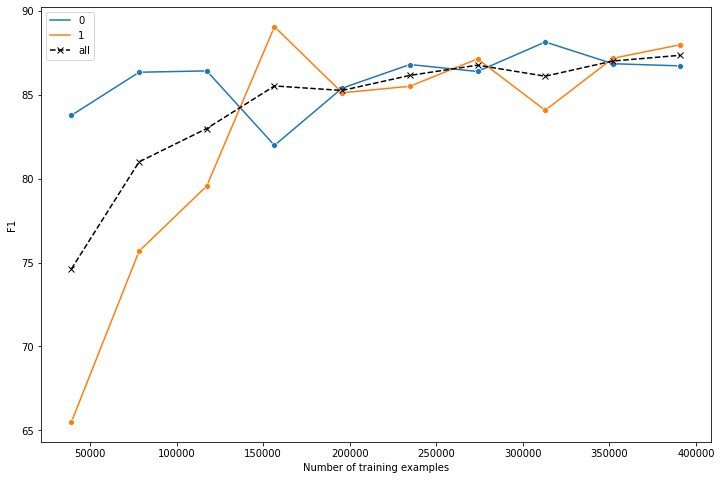

In [61]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df, y='f1', x='num_examples', hue='unanswerable', marker='o', palette='tab10')
plt.plot(overall_f1_perf_df['checkpoint'].map(checkpoint_to_examples), overall_f1_perf_df['overall_F1'], linestyle='--', marker='x', label='all', color='black')
plt.legend()
plt.show()

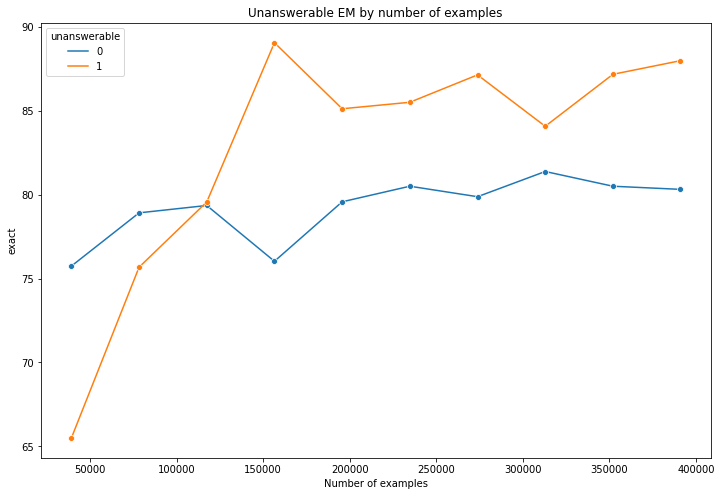

In [62]:
plt.figure(figsize=(12, 8))
plt.title('Unanswerable EM by number of examples')
plt.xlabel('Number of examples')
sns.lineplot(data=full_metrics_df, y='exact', x='num_examples', hue='unanswerable', marker='o')
plt.show()

### Length metrics

#### i. Context length

In [63]:
combined.head()

,id,prediction_text,checkpoint,answers,context,question,title,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable,num_examples,overall_F1
0,56ddde6b9a695914005b9628,France,0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0,39120,74.620678
1,56ddde6b9a695914005b9629,10th and 11th centuries,0,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,Normans,when,100-200,5-10,4,0,39120,74.620678
2,56ddde6b9a695914005b962a,"Denmark, Iceland and Norway",0,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,Normans,other,100-200,5-10,4,0,39120,74.620678
3,56ddde6b9a695914005b962b,Rollo,0,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Normans,who,100-200,0-5,1,0,39120,74.620678
4,56ddde6b9a695914005b962c,10th century,0,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,Normans,what,100-200,5-10,1,0,39120,74.620678


In [64]:
combined['context_length_bin'].unique()

array(['100-200', '200-300', '0-100', '400-500', '300-400', '>500'],
      dtype=object)

In [65]:
full_metrics_df = pd.DataFrame()

for num_examples in combined['num_examples'].unique():
    for label in combined['context_length_bin'].unique():
        
        combined_subset = combined.copy()[
            (combined['context_length_bin'] == label) & 
            (combined['num_examples'] == num_examples)
        ]
        
        id_list = list(combined_subset['id'])
        prediction_text_list = list(combined_subset['prediction_text'])
        answers_list = list(combined_subset['answers'])

        metrics = squad2_evaluation(
            id_list=id_list, 
            prediction_text_list=prediction_text_list, 
            answers_list=answers_list
        )

        metrics_df = pd.DataFrame(metrics, index=[0])
        metrics_df['context_length_bin'] = label
        metrics_df['num_examples'] = num_examples
        
        full_metrics_df = full_metrics_df.append(metrics_df, ignore_index=True)

In [66]:
print(full_metrics_df.shape)
full_metrics_df.head()

(60, 15)


,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,NoAns_exact,NoAns_f1,NoAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,context_length_bin,num_examples
0,71.465026,75.389100,6662,76.477612,84.281249,3350,66.394928,66.394928,3312,71.480036,0.0,75.404111,0.0,100-200,39120
1,69.701087,75.141794,736,72.207792,82.608728,385,66.951567,66.951567,351,69.972826,0.0,75.413533,0.0,200-300,39120
2,69.515603,73.400267,4294,75.154688,83.094121,2101,64.113087,64.113087,2193,69.515603,0.0,73.400267,0.0,0-100,39120
3,77.551020,80.102041,49,80.769231,85.576923,26,73.913043,73.913043,23,81.632653,0.0,84.183673,0.0,400-500,39120
4,74.747475,78.679795,99,81.132075,88.477353,53,67.391304,67.391304,46,77.777778,0.0,81.710098,0.0,300-400,39120


__Context length F1 by number of examples__

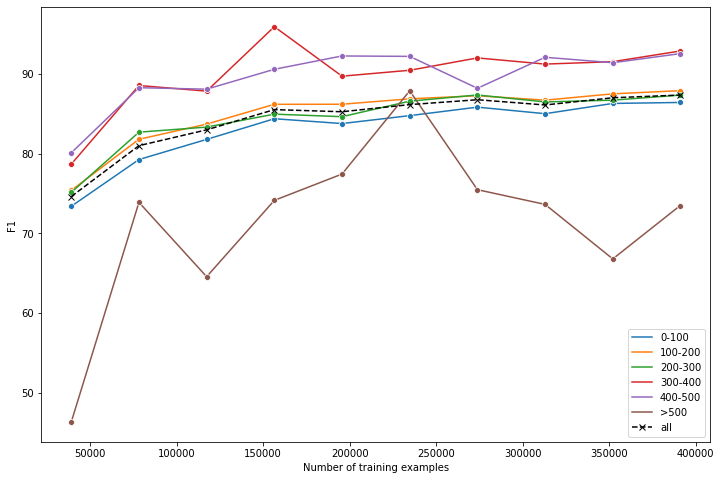

In [67]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(
    data=full_metrics_df, y='f1', x='num_examples', hue='context_length_bin', marker='o',
    hue_order=['0-100', '100-200', '200-300', '300-400', '400-500', '>500'],
    palette='tab10'
)
plt.plot(overall_f1_perf_df['checkpoint'].map(checkpoint_to_examples), overall_f1_perf_df['overall_F1'], linestyle='--', marker='x', label='all', color='black')
plt.legend()
plt.show()

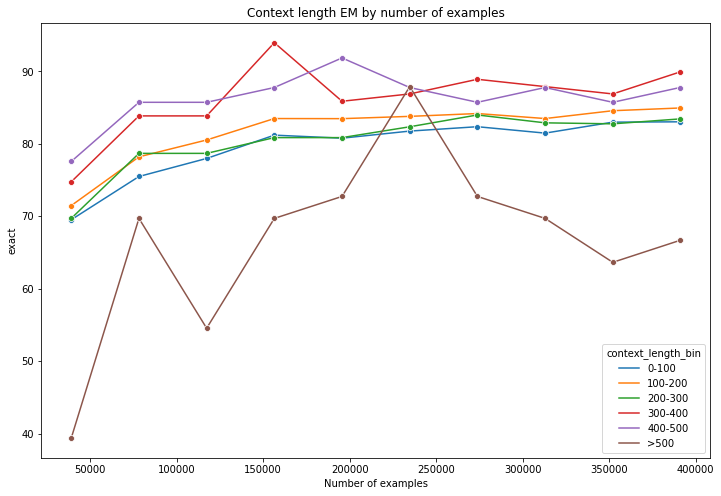

In [68]:
plt.figure(figsize=(12, 8))
plt.title('Context length EM by number of examples')
plt.xlabel('Number of examples')
sns.lineplot(
    data=full_metrics_df, y='exact', x='num_examples', hue='context_length_bin', marker='o',
    hue_order=['0-100', '100-200', '200-300', '300-400', '400-500', '>500'],
    palette='tab10'
)
plt.show()

#### ii. Question length

In [69]:
combined.head()

,id,prediction_text,checkpoint,answers,context,question,title,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable,num_examples,overall_F1
0,56ddde6b9a695914005b9628,France,0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0,39120,74.620678
1,56ddde6b9a695914005b9629,10th and 11th centuries,0,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,Normans,when,100-200,5-10,4,0,39120,74.620678
2,56ddde6b9a695914005b962a,"Denmark, Iceland and Norway",0,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,Normans,other,100-200,5-10,4,0,39120,74.620678
3,56ddde6b9a695914005b962b,Rollo,0,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Normans,who,100-200,0-5,1,0,39120,74.620678
4,56ddde6b9a695914005b962c,10th century,0,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,Normans,what,100-200,5-10,1,0,39120,74.620678


In [70]:
combined['question_length_bin'].unique()

array(['5-10', '0-5', '10-15', '15-20', '20-25', '>25'], dtype=object)

In [71]:
full_metrics_df = pd.DataFrame()

for num_examples in combined['num_examples'].unique():
    for label in combined['question_length_bin'].unique():
        
        combined_subset = combined.copy()[
            (combined['question_length_bin'] == label) & 
            (combined['num_examples'] == num_examples)
        ]
        
        id_list = list(combined_subset['id'])
        prediction_text_list = list(combined_subset['prediction_text'])
        answers_list = list(combined_subset['answers'])

        metrics = squad2_evaluation(
            id_list=id_list, 
            prediction_text_list=prediction_text_list, 
            answers_list=answers_list
        )

        metrics_df = pd.DataFrame(metrics, index=[0])
        metrics_df['question_length_bin'] = label
        metrics_df['num_examples'] = num_examples
        
        full_metrics_df = full_metrics_df.append(metrics_df, ignore_index=True)

In [72]:
print(full_metrics_df.shape)
full_metrics_df.head()

(60, 15)


,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,NoAns_exact,NoAns_f1,NoAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,question_length_bin,num_examples
0,70.274734,74.020967,6661,75.640205,83.627932,3124,65.535765,65.535765,3537,70.274734,0.0,74.020967,0.0,5-10,39120
1,65.487977,71.065542,707,68.154762,79.890888,336,63.072776,63.072776,371,65.629420,0.0,71.206985,0.0,0-5,39120
2,71.845986,75.940524,3662,76.336274,84.117385,1927,66.858790,66.858790,1735,71.873293,0.0,75.967832,0.0,10-15,39120
3,72.067039,76.138277,716,79.470199,85.905091,453,59.315589,59.315589,263,72.206704,0.0,76.277942,0.0,15-20,39120
4,69.811321,76.220698,106,73.333333,82.391919,75,61.290323,61.290323,31,69.811321,0.0,76.220698,0.0,20-25,39120


__Question length F1 by number of examples__

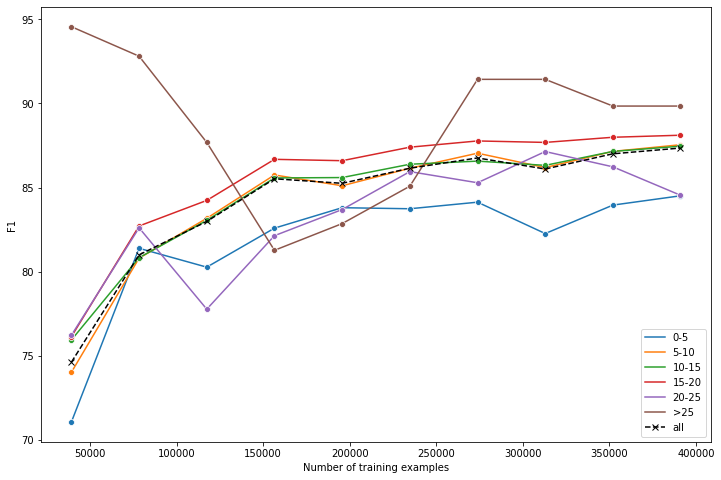

In [73]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(
    data=full_metrics_df, y='f1', x='num_examples', hue='question_length_bin', marker='o',
    hue_order=['0-5', '5-10', '10-15', '15-20', '20-25', '>25'],
    palette='tab10'
)
plt.plot(overall_f1_perf_df['checkpoint'].map(checkpoint_to_examples), overall_f1_perf_df['overall_F1'], linestyle='--', marker='x', label='all', color='black')
plt.legend()
plt.show()

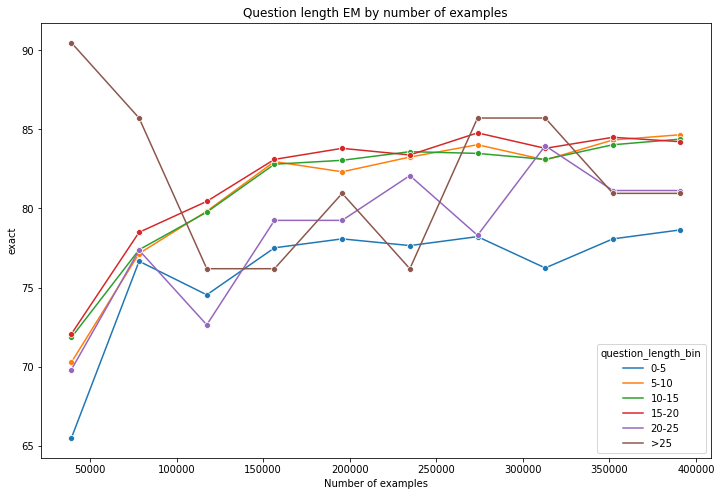

In [74]:
plt.figure(figsize=(12, 8))
plt.title('Question length EM by number of examples')
plt.xlabel('Number of examples')
sns.lineplot(
    data=full_metrics_df, y='exact', x='num_examples', hue='question_length_bin', marker='o',
    hue_order=['0-5', '5-10', '10-15', '15-20', '20-25', '>25'],
    palette='tab10'
)
plt.show()

#### iii. Answer length

In [75]:
combined.head()

,id,prediction_text,checkpoint,answers,context,question,title,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable,num_examples,overall_F1
0,56ddde6b9a695914005b9628,France,0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0,39120,74.620678
1,56ddde6b9a695914005b9629,10th and 11th centuries,0,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,Normans,when,100-200,5-10,4,0,39120,74.620678
2,56ddde6b9a695914005b962a,"Denmark, Iceland and Norway",0,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,Normans,other,100-200,5-10,4,0,39120,74.620678
3,56ddde6b9a695914005b962b,Rollo,0,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Normans,who,100-200,0-5,1,0,39120,74.620678
4,56ddde6b9a695914005b962c,10th century,0,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,Normans,what,100-200,5-10,1,0,39120,74.620678


In [76]:
full_metrics_df = pd.DataFrame()

for num_examples in combined['num_examples'].unique():
    for label in combined['answer_mode_length_bin'].unique():
        
        combined_subset = combined.copy()[
            (combined['answer_mode_length_bin'] == label) & 
            (combined['num_examples'] == num_examples)
        ]
        
        id_list = list(combined_subset['id'])
        prediction_text_list = list(combined_subset['prediction_text'])
        answers_list = list(combined_subset['answers'])

        metrics = squad2_evaluation(
            id_list=id_list, 
            prediction_text_list=prediction_text_list, 
            answers_list=answers_list
        )

        metrics_df = pd.DataFrame(metrics, index=[0])
        metrics_df['answer_mode_length_bin'] = label
        metrics_df['num_examples'] = num_examples
        
        full_metrics_df = full_metrics_df.append(metrics_df, ignore_index=True)

In [77]:
print(full_metrics_df.shape)
full_metrics_df.head()

(110, 15)


,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,best_exact,best_exact_thresh,best_f1,best_f1_thresh,answer_mode_length_bin,num_examples,NoAns_exact,NoAns_f1,NoAns_total
0,78.737113,84.088079,2328,78.737113,84.088079,2328.0,78.737113,0.0,84.088079,0.0,1,39120,NaN,NaN,NaN
1,73.170732,82.455314,410,73.170732,82.455314,410.0,73.170732,0.0,82.455314,0.0,4,39120,NaN,NaN,NaN
2,65.500421,65.500421,5945,NaN,NaN,NaN,100.000000,0.0,100.000000,0.0,0,39120,65.500421,65.500421,5945.0
3,78.426698,86.704078,839,78.426698,86.704078,839.0,78.426698,0.0,86.704078,0.0,3,39120,NaN,NaN,NaN
4,80.980392,86.437553,1530,80.980392,86.437553,1530.0,80.980392,0.0,86.437553,0.0,2,39120,NaN,NaN,NaN


__Answer length F1 by number of examples__

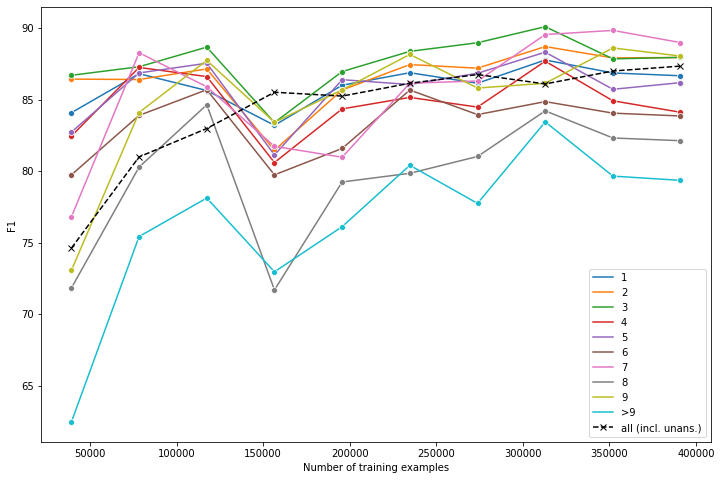

In [85]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(
    data=full_metrics_df[full_metrics_df['answer_mode_length_bin'] != '0'], # Drop unanswerable from plot
    y='f1', x='num_examples', hue='answer_mode_length_bin', marker='o', 
    hue_order=[str(x) for x in range(1, 10)] + ['>9'],
    palette='tab10'
)
plt.plot(overall_f1_perf_df['checkpoint'].map(checkpoint_to_examples), overall_f1_perf_df['overall_F1'], linestyle='--', marker='x', label='all (incl. unans.)', color='black')
plt.legend()
plt.show()

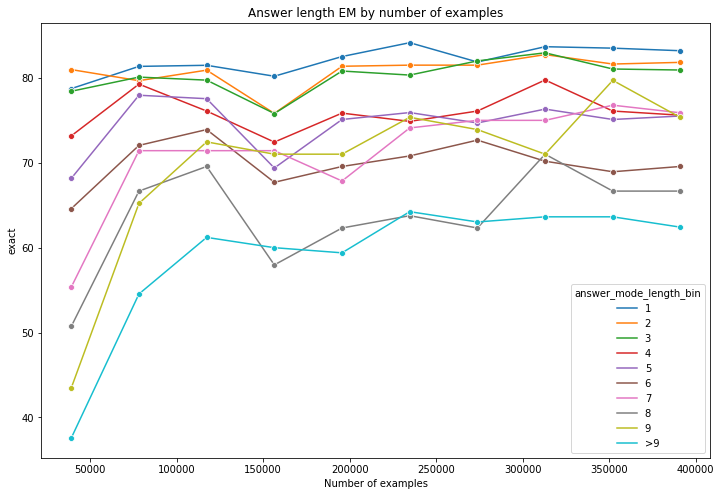

In [86]:
plt.figure(figsize=(12, 8))
plt.title('Answer length EM by number of examples')
plt.xlabel('Number of examples')
sns.lineplot(
    data=full_metrics_df[full_metrics_df['answer_mode_length_bin'] != '0'], # Drop unanswerable from plot 
    y='exact', x='num_examples', hue='answer_mode_length_bin', marker='o', 
    hue_order=[str(x) for x in range(1, 10)] + ['>9'],
    palette='tab10'
)
plt.show()